# Dataloading & Preprocessing

In [1]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.5 MB/s eta 0:00:00:00:01


In [2]:
import os
import torchaudio

from datasets import Dataset
from functools import partial
from transformers import Wav2Vec2Processor


def load_custom_data(root_dir: str):
    audio_paths = []
    texts = []

    for movie_name in os.listdir(root_dir):
        movie_path = os.path.join(root_dir, movie_name)
        if not os.path.isdir(movie_path):
            continue

        for fname in os.listdir(movie_path):
            if fname.endswith(".wav"):
                base = os.path.splitext(fname)[0]
                wav_path = os.path.join(movie_path, f"{base}.wav")
                txt_path = os.path.join(movie_path, f"{base}.txt")

                if os.path.exists(wav_path) and os.path.exists(txt_path):
                    audio_paths.append(wav_path)
                    with open(txt_path, "r", encoding="utf-8") as f:
                        texts.append(f.read().strip())

    return Dataset.from_dict({"audio": audio_paths, "text": texts})

def preprocess(batch, processor, resample_rate = 16_000):
    waveform, sample_rate = torchaudio.load(batch["audio"])

    # resample
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=resample_rate)
    waveform = resampler(waveform)

    # convert to mono
    if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

    # normalize
    waveform = waveform / waveform.abs().max()
    
    input = processor(waveform.squeeze().numpy(), sampling_rate=resample_rate, return_attention_mask=True)
    input_values = input.input_values[0]
    
    batch["input_values"] = input_values
    batch["attention_mask"] = input.attention_mask[0]

    # process text before tokenization
    processed_text = batch["text"].upper().replace(" ", "|").replace("\n", "|")
    batch["labels"] = processor.tokenizer(processed_text).input_ids
    
    return batch

def prepare_dataset(raw_dataset, processor):
    dataset = raw_dataset.train_test_split(test_size=0.1)
    preprocess_fn = partial(preprocess, processor=processor)
    return dataset.map(preprocess_fn, remove_columns=["audio", "text"])

# Trainer

In [3]:
from jiwer import wer
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./wav2vec2-finetuned-moviesubs",
    group_by_length=True,
    dataloader_num_workers=4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    num_train_epochs=80,
    fp16=False,
    learning_rate=1e-6,
    logging_strategy="steps",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    save_total_limit=1,
    remove_unused_columns=False,
    max_grad_norm=0.5,
)

def compute_metrics(pred):
    pred_ids = pred.predictions.argmax(-1)
    
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer_loss = wer(label_str, pred_str)
    return {"wer": wer_loss}

2025-05-11 08:43:36.011847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746953016.239829      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746953016.307388      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DataCollator

In [4]:
class DataCollatorCTC:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, features):
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # pad inputs
        batch = self.processor.pad(input_features, padding=True, return_tensors="pt")
        
        # pad labels
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=True,
                return_tensors="pt"
            )
        
        # replace padding with -100 to ignore loss
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        
        batch["labels"] = labels
        return batch

# Model

In [6]:
import torch
import warnings

from transformers import Wav2Vec2ForCTC

warnings.filterwarnings("ignore")
os.environ["WANDB_DISABLED"] = "true"
model_str = "facebook/wav2vec2-base-960h"

processor = Wav2Vec2Processor.from_pretrained(model_str, do_normalize=True, feature_size=1, padding_value=0.0, return_attention_mask=True)
data_collator = DataCollatorCTC(processor=processor)

raw_dataset = load_custom_data("/kaggle/input/movie2sub-dataset/dataset")
# reduce dataset
# raw_dataset = raw_dataset.shuffle(seed=42).select(range(100))
dataset = prepare_dataset(raw_dataset, processor)

model = Wav2Vec2ForCTC.from_pretrained(
    model_str,
    vocab_size=len(processor.tokenizer),
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer.train()

Map:   0%|          | 0/902 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Wer
1,3.008800,2.004280,0.667170


TrainOutput(global_step=112, training_loss=3.22037410736084, metrics={'train_runtime': 852.9427, 'train_samples_per_second': 2.115, 'train_steps_per_second': 0.131, 'total_flos': 4.844570176512e+17, 'train_loss': 3.22037410736084, 'epoch': 1.9734513274336283})

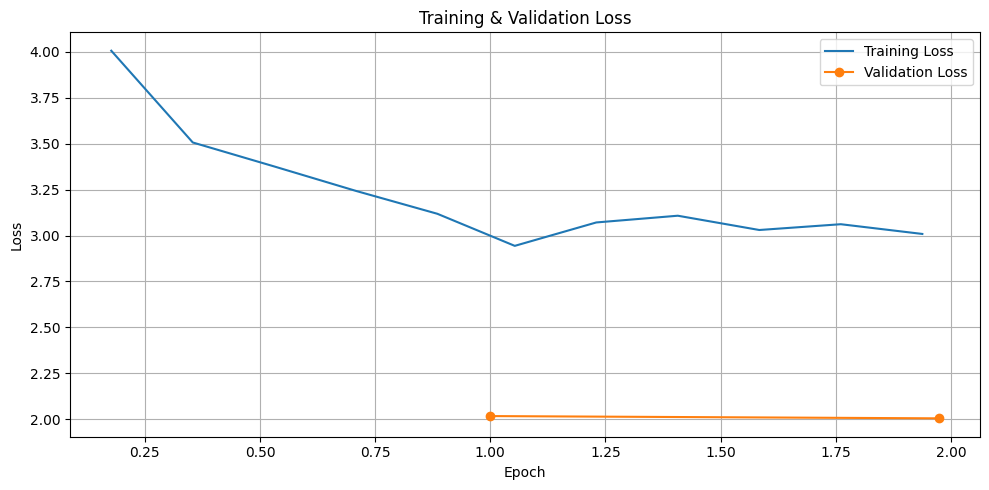

In [8]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_loss = []
train_epochs = []
eval_loss = []
eval_epochs = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss")
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("./train_vs_val_loss.png")
plt.show()

In [11]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    dataset["test"],
    batch_size=4,
    shuffle=False,
    collate_fn=data_collator,
)

for i, batch in enumerate(test_loader):
    with torch.no_grad():
        output = model(input_values=batch["input_values"].to(device))
        print("Logits has NaNs:", torch.isnan(output.logits).any().item())
    
        predicted_ids = torch.argmax(output.logits, dim=-1)
        decoded_text = processor.decode(predicted_ids[0])
    
        print(f"Decoded text: {decoded_text}")
        break

Logits has NaNs: False
Decoded text: SAID A HOUSE FOR O PARTMEN AS THE HAUS A HOI WAS MYRY WHAT AVE I IN ED OR SHED BEN A FACTO NIGGLA O COME IN A  O DEA A MISIME YOU KNOW MY PLEASURE OF LIVING THE MANIS THAT I HAVE A GOOD LOOKING WOMAN THAT I'M WITH A GOOD LOOKING I WOULDN'T GO O WIH A WOMAN  T  BE O NE A HA HA
